# Assignment 1 - Question 6

## Setup: Libraries and Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Random seed
seed = 42
np.random.seed(seed)

print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

NumPy: 2.2.6
Matplotlib: 3.10.8


## Prepare Reusable Functions

### Construct a random Normal (Gaussian) Distribution

In [2]:
def simulate_normal(mu_true=0, sigma_true=2.0, n=20, seed=0):
    rng = np.random.default_rng(seed)
    x = rng.normal(loc=mu_true, scale=sigma_true, size=n).astype(np.float32)
    return x

# Example
x_sim = simulate_normal(mu_true=10.0, sigma_true=2.0, n=20, seed=seed)
print(f"x_sim[:5]: {x_sim[:5]},\nmean: {x_sim.mean()},\nstd: {x_sim.std(ddof=0)}")

x_sim[:5]: [10.609434   7.920032  11.500902  11.881129   6.0979295],
mean: 9.934135437011719,
std: 1.696288824081421


### Construct the Bayesian Linear Regression form

In [3]:
def linear_regression_simulate(n=20, w0=-0.3, w1=0.5, sigma=0.2, seed=seed, dist:np.ndarray=None):
    rng = np.random.default_rng(seed)
    x = rng.uniform(low=-1, high=1, size=n).astype(np.float32)
    if dist is None:
        dist = simulate_normal(mu_true=0, sigma_true=sigma, n=n, seed=seed)
    else:
        dist = dist.astype(np.float32)

    # Adding noise based on sigma to make it realistic
    y = w0 + w1 * x + dist
    return x, y

# Example
norm_dist = simulate_normal(mu_true=0, sigma_true=0.2, n=20, seed=seed)
x_sim, y_sim = linear_regression_simulate(n=20, w0=2.0, w1=5.0, seed=seed, dist=norm_dist)
print(f"x_sim[:5]: {x_sim[:5]},\ny_sim[:5]: {y_sim[:5]},\nmean x_sim: {x_sim.mean()},\nmean y_sim: {y_sim.mean()},\nstd x_sim: {x_sim.std(ddof=0)},\nstd y_sim: {y_sim.std(ddof=0)}")

x_sim[:5]: [ 0.5479121  -0.12224312  0.71719587  0.39473605 -0.8116453 ],
y_sim[:5]: [ 4.800504   1.1807876  5.7360697  4.161793  -2.4484336],
mean x_sim: 0.14768439531326294,
mean y_sim: 2.7318358421325684,
std x_sim: 0.5546502470970154,
std y_sim: 2.8611888885498047


### Compute the Likelihoods, Posteriors, and Data Samples

In [4]:
def compute_bayesian_steps(x, y, sigma, prior_mu, prior_cov, n=100):
    """Computes likelihood, posterior, and weight samples for visualization."""
    # Create grid for weights w0, w1
    w_range = np.linspace(-1, 1, n)
    W0, W1 = np.meshgrid(w_range, w_range)
    pos = np.dstack((W0, W1))
    
    # Prior
    prior_pdf = multivariate_normal(prior_mu, prior_cov).pdf(pos)
    
    # Likelihood of the MOST RECENT point
    # Likelihood: p(y|x,w) = N(y | w0 + w1*x, sigma^2)
    last_x, last_y = x[-1], y[-1]
    likelihood_pdf = np.exp(-1/(2*sigma**2) * (last_y - (W0 + W1*last_x))**2)
    
    # Posterior
    Phi = np.vstack([np.ones(len(x)), x]).T
    prec_prior = np.linalg.inv(prior_cov)
    prec_post = prec_prior + (1/sigma**2) * (Phi.T @ Phi)
    cov_post = np.linalg.inv(prec_post)
    mu_post = cov_post @ (prec_prior @ prior_mu + (1/sigma**2) * Phi.T @ y)
    
    post_pdf = multivariate_normal(mu_post, cov_post).pdf(pos)
    
    # Data Samples
    w_samples = np.random.multivariate_normal(mu_post, cov_post, 10)
    
    return {
        "Prior": prior_pdf,
        "Likelihood": likelihood_pdf,
        "Posterior": post_pdf,
        "Weight Samples": w_samples
    }

In [5]:
def plot_bayesian_regression(steps_data):
    n_rows = len(steps_data)
    fig, axes = plt.subplots(n_rows, 3, figsize=(12, 4 * n_rows))
    
    x_grid = np.linspace(-1, 1, 10)
    
    for i, data in enumerate(steps_data):
        # Column 1: Likelihood
        if i > 0:
            axes[i, 0].contourf(np.linspace(-1,1,100), np.linspace(-1,1,100), data['Likelihood'], cmap='viridis')
        axes[i, 0].set_title("Likelihood")
        axes[i, 0].set_xlabel("w0")
        axes[i, 0].set_ylabel("w1")
        
        # Column 2: Posterior
        axes[i, 1].contourf(np.linspace(-1,1,100), np.linspace(-1,1,100), data['Posterior'], cmap='viridis')
        axes[i, 1].set_title("Prior/Posterior")
        axes[i, 1].set_xlabel("w0")
        axes[i, 1].set_ylabel("w1")
        
        # Column 3: Data Space
        for w in data['Weight Samples']:
            axes[i, 2].plot(x_grid, w[0] + w[1]*x_grid, color='red', alpha=0.5)
        if len(data['observed_x']) > 0:
            axes[i, 2].scatter(data['observed_x'], data['observed_y'], s=30, facecolors='none', edgecolors='blue')
        axes[i, 2].set_xlim(-1, 1); axes[i, 2].set_ylim(-1, 1)
        axes[i, 2].set_title("Data Space")
        axes[i, 2].set_xlabel("x")
        axes[i, 2].set_ylabel("y")

    plt.tight_layout()
    plt.show()

## Putting Altogether!

### Question 6 (a)
Goal: Implement Python code that reproduces the three-column, four-row figure for Bayesian
linear regression with Gaussian prior and noise. Use the parameters specified:
* Number of training points: 100,
* Noise standard deviation: 0.2,
* Prior precision (α) : 2.0,
* Likelihood standard deviation: 0.2,
* Data indices visualized: 0, 1, 2, 100

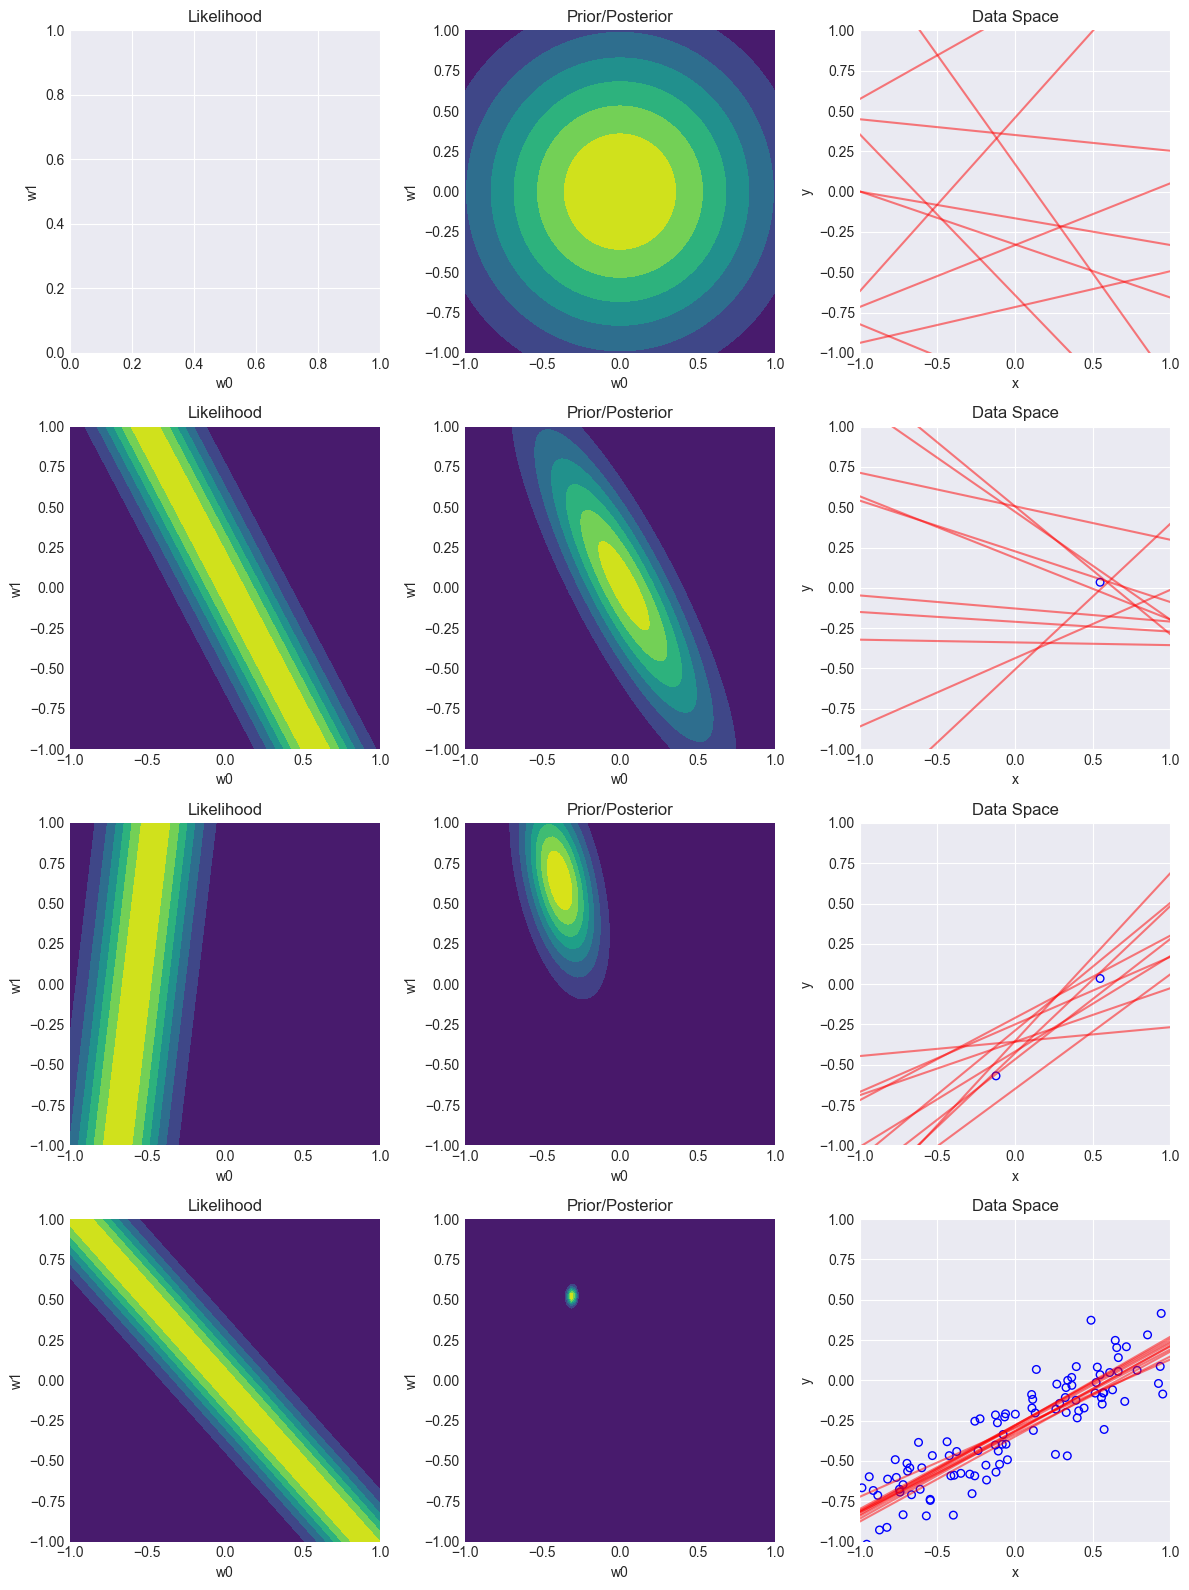

In [6]:
true_w = [-0.3, 0.5] # weights from y = w0 + w1*x + noise (not specified in question)
std = 0.2
alpha = 2.0  # Prior precision
m0, S0 = np.array([0, 0]), np.eye(2) * (1/alpha)

# Simulate 100 points
x_all, y_all = linear_regression_simulate(n=100, w0=true_w[0], w1=true_w[1], sigma=std, seed=seed)
# Pick 4 Snapshots to display in 4 rows 
snapshots = []
for n in [0, 1, 2, 100]:
    x_slice, y_slice = x_all[:n], y_all[:n]
    
    # For N=0, the posterior is just the prior
    if n == 0:
        like, post, samples, m_n, S_n = None, multivariate_normal(m0, S0).pdf(np.dstack(np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100)))),np.random.multivariate_normal(m0, S0, 10), m0, S0
        like = np.zeros((100,100))
        bayes_res = {
            "Prior": post,
            "Likelihood": like,
            "Posterior": post,
            "Weight Samples": samples
        }
    else:
        bayes_res = compute_bayesian_steps(x_slice, y_slice, std, m0, S0)
    
    bayes_res['observed_x'] = x_slice
    bayes_res['observed_y'] = y_slice
    snapshots.append(bayes_res)

plot_bayesian_regression(snapshots)

### Question 6 (b)

(i) **Likelihood Shape**: 
* When there is no data, the only data sample produces a diagonal shape from left upper corner (where w1 = 1 and w0 = 0), to the bottom right corner (where w1 = 0 and w0 = 1).
* When the sample size is very small, it is a parallel thin rectangular shape skewed to the left. 
* When the sample size grows it tends to become a diagonal shape again. 

#### Explaination
Linear Regression could be formulated as below, 
$$y_n = w_0 + w_1 x_n$$

If we rearrange the terms, we have: 
$$w_1 = -\frac{1}{x_n} w_0 + \frac{y_n}{x_n}$$

##### The Line
The likelihood graphs are controlled by the weights $w_0$ and $w_1$. We have $w_1$ on the y-axis and $w_0$ on the x-axis in our likelihood plot. From the above rearranged formula, the slope is obviously $-\frac{1}{x_n}$, while the y-intercept is $\frac{y_n}{x_n}$.The negativity of the gradient tells the linear curve is curving downward. The fraction means that the gradient is inversely proportional to $x_n$ ($n$-th sample from the sample distribution). This causes the curves of likelihoods to always go downward. Then, how the line bend towards depends on where it should land on the y-axis, which is controlled by the division of $y_n$ over $x_n$.

##### The Width
Related to Bayesian Linear Regression, the width is actually controlled by the variance $\sigma^2$, which refers to the spread of the data. In a full picture, if we see how a posterior is formed (shown below), assuming conjugacy in a Normal (Gaussian) distribution, the posterior, which is given by the model's learned data, should be proportional to the product of likelihood and prior. 
$$p(\mathbf{w} \mid \text{Data}) \propto p(\mathbf{w}) \times \prod_{n=1}^{N} p(y_n \mid x_n, \mathbf{w})$$

That said, when we plot the relationships of weight terms, each data point forms a stripe on the line, making the (uncertainty) band thicker.

(ii) **Posterior Center**

In [7]:
def find_center(posterior_pdf: np.ndarray):
    # Find the flat index of the maximum value
    max_idx = np.argmax(posterior_pdf)

    # Convert flat index to (row, col) grid coordinates
    row, col = np.unravel_index(max_idx, posterior_pdf.shape)

    # Convert grid coordinates back to w0, w1 values
    w_range = np.linspace(-1, 1, 100)
    w0_center = w_range[col]
    w1_center = w_range[row]

    return w0_center, w1_center

data_sizes = [0, 1, 2, 100]
for idx, snap in enumerate(snapshots):
    center = find_center(snap["Posterior"])
    print(f"The center of posterior with {data_sizes[idx]} samples: w0={center[0]:.2f}, w1={center[1]:.2f}")

The center of posterior with 0 samples: w0=-0.01, w1=-0.01
The center of posterior with 1 samples: w0=0.03, w1=0.01
The center of posterior with 2 samples: w0=-0.39, w1=0.66
The center of posterior with 100 samples: w0=-0.31, w1=0.52


(iii) **Posterior Spread & Correlation**

In [8]:
# Find Correlation(w0, w1)
for idx, snap in enumerate(snapshots):
    mu_post = np.array(find_center(snap["Posterior"]))
    # Estimate covariance from posterior pdf
    w_range = np.linspace(-1, 1, 100)
    W0, W1 = np.meshgrid(w_range, w_range)
    pos = np.dstack((W0, W1))
    posterior_pdf = snap["Posterior"]
    # Normalize the posterior pdf
    posterior_pdf /= np.sum(posterior_pdf)
    # Compute expected values
    E_w0 = np.sum(W0 * posterior_pdf)
    E_w1 = np.sum(W1 * posterior_pdf)
    E_w0w1 = np.sum(W0 * W1 * posterior_pdf)
    E_w0_sq = np.sum(W0**2 * posterior_pdf)
    E_w1_sq = np.sum(W1**2 * posterior_pdf)
    # Compute covariance
    cov_w0w1 = E_w0w1 - E_w0 * E_w1
    var_w0 = E_w0_sq - E_w0**2
    var_w1 = E_w1_sq - E_w1**2
    corr_w0w1 = cov_w0w1 / (np.sqrt(var_w0) * np.sqrt(var_w1))
    print(f"Correlation between w0 and w1 with {data_sizes[idx]} samples: {corr_w0w1:.4f} ({'positive' if corr_w0w1 > 0 else 'negative' if corr_w0w1 < 0 else 'zero'}) correlation")

Correlation between w0 and w1 with 0 samples: 0.0000 (positive) correlation
Correlation between w0 and w1 with 1 samples: -0.7894 (negative) correlation
Correlation between w0 and w1 with 2 samples: -0.3902 (negative) correlation
Correlation between w0 and w1 with 100 samples: 0.0486 (positive) correlation


In [9]:
# Determine Uncertainty: High/Medium/Low
for idx, snap in enumerate(snapshots):
    posterior_pdf = snap["Posterior"]
    # Normalize the posterior pdf
    posterior_pdf /= np.sum(posterior_pdf)
    # Compute variances
    w_range = np.linspace(-1, 1, 100)
    W0, W1 = np.meshgrid(w_range, w_range)
    E_w0 = np.sum(W0 * posterior_pdf)
    E_w1 = np.sum(W1 * posterior_pdf)
    E_w0_sq = np.sum(W0**2 * posterior_pdf)
    E_w1_sq = np.sum(W1**2 * posterior_pdf)
    var_w0 = E_w0_sq - E_w0**2
    var_w1 = E_w1_sq - E_w1**2
    std_w0 = np.sqrt(var_w0)
    std_w1 = np.sqrt(var_w1)
    
    uncertainty_level_w0 = "High" if std_w0 > 0.7 else "Medium" if std_w0 > 0.5 else "Low"
    uncertainty_level_w1 = "High" if std_w1 > 0.7 else "Medium" if std_w1 > 0.5 else "Low"
    
    print(f"Uncertainty in w0 with {data_sizes[idx]} samples: {uncertainty_level_w0} (std: {std_w0:.4f})")
    print(f"Uncertainty in w1 with {data_sizes[idx]} samples: {uncertainty_level_w1} (std: {std_w1:.4f})")

Uncertainty in w0 with 0 samples: Medium (std: 0.5074)
Uncertainty in w1 with 0 samples: Medium (std: 0.5074)
Uncertainty in w0 with 1 samples: Low (std: 0.3130)
Uncertainty in w1 with 1 samples: Low (std: 0.4878)
Uncertainty in w0 with 2 samples: Low (std: 0.1506)
Uncertainty in w1 with 2 samples: Low (std: 0.2872)
Uncertainty in w0 with 100 samples: Low (std: 0.0200)
Uncertainty in w1 with 100 samples: Low (std: 0.0367)


(iv) **Convergence**

In [10]:
# Track posterior center movement across snapshots
posterior_centers = []
for snap in snapshots:
    center = find_center(snap["Posterior"])
    posterior_centers.append(center)

# Compare distances from true weights
true_weights = np.array(true_w)
print("Posterior Center Movement Analysis:")
print(f"True weights: w0={true_w[0]}, w1={true_w[1]}\n")

distances = []
for idx, center in enumerate(posterior_centers):
    center_array = np.array(center)
    distance = np.linalg.norm(center_array - true_weights)
    distances.append(distance)
    print(f"N={data_sizes[idx]:3d}: center=({center[0]:6.3f}, {center[1]:6.3f}), distance to true={distance:.4f}")

# Determine movement direction
print("\nConvergence Analysis:")
for i in range(1, len(distances)):
    movement = distances[i] - distances[i-1]
    direction = "Closer" if movement < -0.001 else "Farther" if movement > 0.001 else "Unchanged"
    print(f"N={data_sizes[i-1]} --> N={data_sizes[i]}: {direction} (Movement={movement:+.4f})")

Posterior Center Movement Analysis:
True weights: w0=-0.3, w1=0.5

N=  0: center=(-0.010, -0.010), distance to true=0.5867
N=  1: center=( 0.030,  0.010), distance to true=0.5908
N=  2: center=(-0.394,  0.657), distance to true=0.1826
N=100: center=(-0.313,  0.515), distance to true=0.0200

Convergence Analysis:
N=0 --> N=1: Farther (Movement=+0.0041)
N=1 --> N=2: Closer (Movement=-0.4083)
N=2 --> N=100: Closer (Movement=-0.1625)
